## *Influential nodes identification using network local structural properties*
## *Implementaion on tiny network*
### Kartabya Krishna

---

### Importing Libraries 

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import defaultdict
import math
import random
from scipy.stats import kendalltau

### Loading the tiny network

In [38]:
# Load the CSV file containing the edges
edges_df = pd.read_csv('tiny.csv', header=None)
edges = [tuple(x) for x in edges_df.values]

# Create the graph and add edges
G = nx.Graph()
G.add_edges_from(edges)

# Print the edges to verify
print(list(G.edges))

[(1, 2), (2, 4), (2, 3), (4, 5), (4, 6), (4, 3), (3, 6)]


### Estimating Network Characteristics

In [39]:
# Calculate characteristics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

# Degree statistics
degrees = [d for n, d in G.degree()]
max_degree = max(degrees)
min_degree = min(degrees)
avg_degree = sum(degrees) / num_nodes

# Assortativity
assortativity = nx.degree_assortativity_coefficient(G)

# Triangle statistics
num_triangles = sum(nx.triangles(G).values()) // 3  # Divide by 3 to avoid triple-counting
avg_num_triangles = num_triangles / num_nodes
max_num_triangles = max(nx.triangles(G).values())

# Clustering
avg_clustering = nx.average_clustering(G)
fraction_closed_triangles = 3 * num_triangles / nx.transitivity(G) if nx.transitivity(G) != 0 else 0

# k-core
core_number = nx.core_number(G)
max_k_core = max(core_number.values())

# Clique bound (lower bound for the maximum clique)
clique_bound = max(len(clique) for clique in nx.find_cliques(G))

# Print the results
print("Here are the characteristics of the network:")
print(f"• Nodes: {num_nodes}")
print(f"• Edges: {num_edges}")
print(f"• Density: {density:.6f}")

print("\n• Degree Statistics:")
print(f"  o Maximum Degree: {max_degree}")
print(f"  o Minimum Degree: {min_degree}")
print(f"  o Average Degree: {avg_degree:.2f}")

print(f"\n• Assortativity: {assortativity:.6f}")

print("\n• Triangle Statistics:")
print(f"  o Number of Triangles: {num_triangles}")
print(f"  o Average Number of Triangles: {avg_num_triangles:.2f}")
print(f"  o Maximum Number of Triangles: {max_num_triangles}")

print("\n• Clustering:")
print(f"  o Average Clustering Coefficient: {avg_clustering:.6f}")


print(f"\n• k-core: Maximum k-core of {max_k_core}")
print(f"• Clique Bound: Lower bound of the maximum clique is {clique_bound}")


Here are the characteristics of the network:
• Nodes: 6
• Edges: 7
• Density: 0.466667

• Degree Statistics:
  o Maximum Degree: 4
  o Minimum Degree: 1
  o Average Degree: 2.33

• Assortativity: -0.458333

• Triangle Statistics:
  o Number of Triangles: 2
  o Average Number of Triangles: 0.33
  o Maximum Number of Triangles: 2

• Clustering:
  o Average Clustering Coefficient: 0.388889

• k-core: Maximum k-core of 2
• Clique Bound: Lower bound of the maximum clique is 3


### Graph Visualization

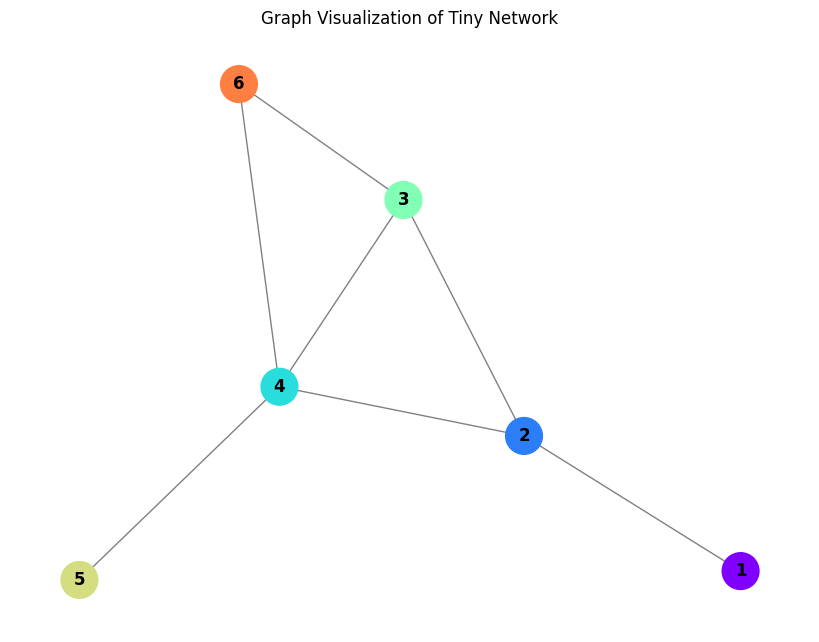

In [40]:
# Assign a unique color to each node
node_colors = cm.rainbow([i / len(G.nodes) for i in range(len(G.nodes))])

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color=node_colors, node_size=700, edge_color='gray', font_weight='bold', font_size=12)
plt.title("Graph Visualization of Tiny Network")
plt.show()


## Step 1 - Construct the Network

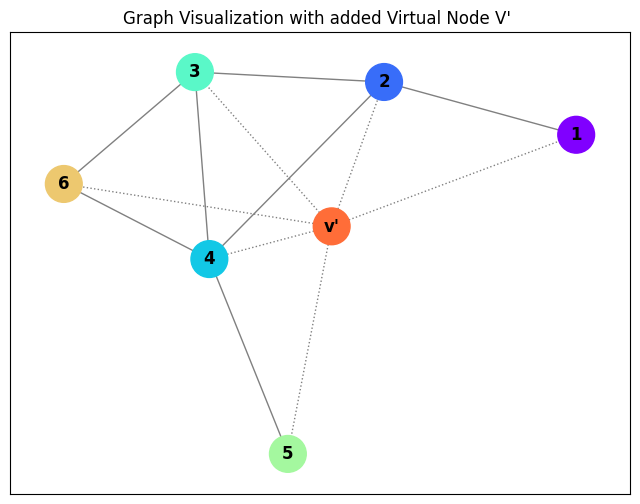

In [41]:
# Add the virtual node `v'` and connect it to all other nodes
virtual_node = 'v\''
nodes_list = list(G.nodes())  # Create a list of nodes to avoid runtime error
for node in nodes_list:
    G.add_edge(virtual_node, node)

# Assign a unique color to each node
node_colors = cm.rainbow([i / len(G.nodes) for i in range(len(G.nodes))])

# Define layout only once to keep node positions consistent
pos = nx.spring_layout(G, seed=42)

# Draw nodes
plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=700)

# Separate solid and dotted edges
solid_edges = edges
dotted_edges = [(virtual_node, node) for node in nodes_list]

# Draw edges
nx.draw_networkx_edges(G, pos=pos, edgelist=solid_edges, edge_color='gray')
nx.draw_networkx_edges(G, pos=pos, edgelist=dotted_edges, style='dotted', edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos=pos, font_weight='bold', font_size=12)

plt.title("Graph Visualization with added Virtual Node V' ")
plt.show()


In [42]:
edges_df = pd.read_csv('tiny.csv', header=None)
edges = [tuple(x) for x in edges_df.values]
G = nx.Graph()
G.add_edges_from(edges)

## Step 2 - Calculate the weights of the edges

#### Virtual Edge Weights

In [43]:
# Calculate the number of nodes in the graph (this will be k(v'))
k_v_prime = len(G.nodes)

# Initialize a dictionary to store virtual edge weights
virtual_edge_weights = {}

# Calculate W_mv' for each node
for node in G.nodes:
    k_vm = G.degree[node]  # Degree of node v_m

    # Calculate W_mv'
    if (k_vm + k_v_prime) > 0:
        W_mv_prime = (k_vm ** 2 * k_v_prime) / (k_vm + k_v_prime)
    else:
        W_mv_prime = 0

    # Store the virtual edge weight for the node
    virtual_edge_weights[node] = W_mv_prime

# Display the virtual edge weights for all nodes
print("Virtual edge weights W_mv' :",virtual_edge_weights)


Virtual edge weights W_mv' : {1: 0.8571428571428571, 2: 6.0, 4: 9.6, 3: 6.0, 5: 0.8571428571428571, 6: 3.0}


In [44]:
import networkx as nx
import numpy as np

# Create the graph and add edges
edges_df = pd.read_csv('tiny.csv', header=None)
edges = [tuple(x) for x in edges_df.values]
G = nx.Graph()
G.add_edges_from(edges)

# Step 1: Calculate degrees
degree = dict(G.degree())

# Map node numbers to matrix indices
node_list = list(G.nodes)
node_index = {node: i for i, node in enumerate(node_list)}

# Initialize a matrix to store edge weights based on the number of nodes
num_nodes = len(node_list)
edge_weights_matrix = np.zeros((num_nodes, num_nodes))

# Step 2: Calculate weights for each edge
for u, v in G.edges:
    k_u = degree[u]
    k_v = degree[v]

    # Count common neighbors to determine T_mn
    common_neighbors = set(G.neighbors(u)).intersection(G.neighbors(v))
    T_mn = len(common_neighbors)

    # Print debugging information for each edge in the loop
    print(f"\nProcessing edge ({u}, {v}):")
    print(f"Degrees: k({u}) = {k_u}, k({v}) = {k_v}")
    print(f"Common neighbors of {u} and {v}: {common_neighbors} (T_mn = {T_mn})")
    
    # Ensure R_mn is calculated consistently using the larger degree
    if k_u > k_v:
        R_mn = k_u / (k_u + k_v)
    else:
        R_mn = k_v / (k_u + k_v)
    print(f"R_mn = {R_mn}")

    # Calculate W_mn using the formula
    if (T_mn / 2) + 1 > 0:
        W_mn = ((k_u - T_mn) * (k_v - T_mn) * R_mn) / ((T_mn / 2) + 1)
    else:
        W_mn = 0  # Edge has no contribution if no triangles
    print(f"Calculated W_mn for edge ({u}, {v}) = {W_mn}")

    # Store the weight in the edge_weights_matrix using mapped indices
    edge_weights_matrix[node_index[u], node_index[v]] = W_mn
    edge_weights_matrix[node_index[v], node_index[u]] = W_mn  # Symmetric matrix

# Specifically check for the weight of edge E(4, 2)
print(f"\nFinal Weight of E42: {edge_weights_matrix[node_index[4], node_index[2]]}")



Processing edge (1, 2):
Degrees: k(1) = 1, k(2) = 3
Common neighbors of 1 and 2: set() (T_mn = 0)
R_mn = 0.75
Calculated W_mn for edge (1, 2) = 2.25

Processing edge (2, 4):
Degrees: k(2) = 3, k(4) = 4
Common neighbors of 2 and 4: {3} (T_mn = 1)
R_mn = 0.5714285714285714
Calculated W_mn for edge (2, 4) = 2.2857142857142856

Processing edge (2, 3):
Degrees: k(2) = 3, k(3) = 3
Common neighbors of 2 and 3: {4} (T_mn = 1)
R_mn = 0.5
Calculated W_mn for edge (2, 3) = 1.3333333333333333

Processing edge (4, 5):
Degrees: k(4) = 4, k(5) = 1
Common neighbors of 4 and 5: set() (T_mn = 0)
R_mn = 0.8
Calculated W_mn for edge (4, 5) = 3.2

Processing edge (4, 6):
Degrees: k(4) = 4, k(6) = 2
Common neighbors of 4 and 6: {3} (T_mn = 1)
R_mn = 0.6666666666666666
Calculated W_mn for edge (4, 6) = 1.3333333333333333

Processing edge (4, 3):
Degrees: k(4) = 4, k(3) = 3
Common neighbors of 4 and 3: {2, 6} (T_mn = 2)
R_mn = 0.5714285714285714
Calculated W_mn for edge (4, 3) = 0.5714285714285714

Processin

In [45]:
for u, v in G.edges:
    k_u = degree[u]
    k_v = degree[v]

    # Count common neighbors to determine T_mn
    common_neighbors = set(G.neighbors(u)).intersection(G.neighbors(v))
    T_mn = len(common_neighbors)
    print(f"Calculated T_mn for edge ({u}, {v}) = {T_mn}")

Calculated T_mn for edge (1, 2) = 0
Calculated T_mn for edge (2, 4) = 1
Calculated T_mn for edge (2, 3) = 1
Calculated T_mn for edge (4, 5) = 0
Calculated T_mn for edge (4, 6) = 1
Calculated T_mn for edge (4, 3) = 2
Calculated T_mn for edge (3, 6) = 1


In [46]:
edge_weights_matrix

array([[0.        , 2.25      , 0.        , 0.        , 0.        ,
        0.        ],
       [2.25      , 0.        , 2.28571429, 1.33333333, 0.        ,
        0.        ],
       [0.        , 2.28571429, 0.        , 0.57142857, 3.2       ,
        1.33333333],
       [0.        , 1.33333333, 0.57142857, 0.        , 0.        ,
        0.8       ],
       [0.        , 0.        , 3.2       , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.33333333, 0.8       , 0.        ,
        0.        ]])

## Step 2 - Total Weight Calculation

In [47]:
total_weight = {}

# Step 2: Calculate total weight for each node
for node in G.nodes:
    W_mv_prime = virtual_edge_weights[node]  # Get W_mv' for the node
    
    # Sum the weights for neighbors
    total_weight[node] = W_mv_prime  # Initialize with W_mv'
    
    # Sum the weights of the edges between node and its neighbors
    for neighbor in G.neighbors(node):
        W_mn = edge_weights_matrix[node_index[node], node_index[neighbor]]
        total_weight[node] += W_mn

# Display the total weights for each node
print("Total Weight per Node:", total_weight)

Total Weight per Node: {1: 3.107142857142857, 2: 11.869047619047619, 4: 16.99047619047619, 3: 8.704761904761904, 5: 4.057142857142857, 6: 5.133333333333333}


## Step 3 -  Calculate the first order edge effect

In [48]:
# Initialize the entropy dictionary to store entropy values for each node
entropy = {}

# Step 3: Calculate entropy for each node
for node in G.nodes:
    W_m = total_weight[node]  # Fetch Wm (total weight of node)
    W_mv_prime = virtual_edge_weights[node]  # Fetch Wmv' from the virtual edge weights array

    # Calculate entropy for the virtual edge Emv'
    if W_m > 0 and W_mv_prime > 0:
        entropy_m_v_prime = -(W_mv_prime / W_m) * math.log2(W_mv_prime / W_m)
    else:
        entropy_m_v_prime = 0

    # Initialize entropy of the node with the virtual edge entropy
    entropy[node] = entropy_m_v_prime

    # Calculate entropy for each neighbor edge Emn
    for neighbor in G.neighbors(node):
        W_mn = edge_weights_matrix[node_index[node], node_index[neighbor]]  # Fetch Wmn from the matrix
        if W_m > 0 and W_mn > 0:
            entropy_m_n = -(W_mn / W_m) * math.log2(W_mn / W_m)
        else:
            entropy_m_n = 0
        # Add the neighbor edge entropy to the total entropy of the node
        entropy[node] += entropy_m_n

# Display the entropy values for each node
print("Entropy per Node:", entropy)


Entropy per Node: {1: 0.8497511372532974, 2: 1.764308820746587, 4: 1.7610548225680458, 3: 1.3590604500184549, 5: 0.743898745288434, 6: 1.3759878232762457}


In [49]:
# Step 4: Calculate core numbers for each node
k_core = nx.core_number(G)  # Returns a dictionary of core numbers
print("k-core values are" , k_core)
# Initialize the influence dictionary
influence = {}

# Calculate influence for each node
for node in G.nodes:
    influence[node] = entropy[node] * k_core[node]

# Display the influence values for each node
print("Influence per Node:", influence)

k-core values are {1: 1, 2: 2, 4: 2, 3: 2, 5: 1, 6: 2}
Influence per Node: {1: 0.8497511372532974, 2: 3.528617641493174, 4: 3.5221096451360916, 3: 2.7181209000369098, 5: 0.743898745288434, 6: 2.7519756465524914}


## Step 4 - Calculate the Total Influence

In [50]:
# Initialize the total influence dictionary
total_influence = {}

# Calculate total influence for each node
for node in G.nodes:
    # Start with the influence of the node itself
    total_influence[node] = influence[node]
    
    # Add the influence of each neighbor
    for neighbor in G.neighbors(node):
        total_influence[node] += influence[neighbor]

# Display the total influence values for each node
print("Total Influence per Node:", total_influence)
ranked_nodes_lenc = [k for k, v in sorted(total_influence.items(), key=lambda item: item[1], reverse=True)]
print("Ranked Nodes based on the decreasing order of Influence ",ranked_nodes_lenc)

Total Influence per Node: {1: 4.378368778746471, 2: 10.618599323919472, 4: 13.2647225785071, 3: 12.520823833218667, 5: 4.266008390424526, 6: 8.992206191725494}
Ranked Nodes based on the decreasing order of Influence  [4, 3, 2, 6, 1, 5]


In [56]:
# Sort nodes based on influence in descending order and select the top 
top_nodes = sorted(total_influence.items(), key=lambda item: item[1], reverse=True)[:10]

# Print the top 10 nodes with their influence scores and degrees
print("Top Nodes based on the decreasing order of Influence (with Degrees):")
for node, influence in top_nodes:
    degree = G.degree(node)
    print(f"Node {node}: Influence = {influence}, Degree = {degree}")

Top Nodes based on the decreasing order of Influence (with Degrees):
Node 4: Influence = 13.2647225785071, Degree = 4
Node 3: Influence = 12.520823833218667, Degree = 3
Node 2: Influence = 10.618599323919472, Degree = 3
Node 6: Influence = 8.992206191725494, Degree = 2
Node 1: Influence = 4.378368778746471, Degree = 1
Node 5: Influence = 4.266008390424526, Degree = 1


## Correlation between significance evaluation indicator of different algorithms and SIR model infection.

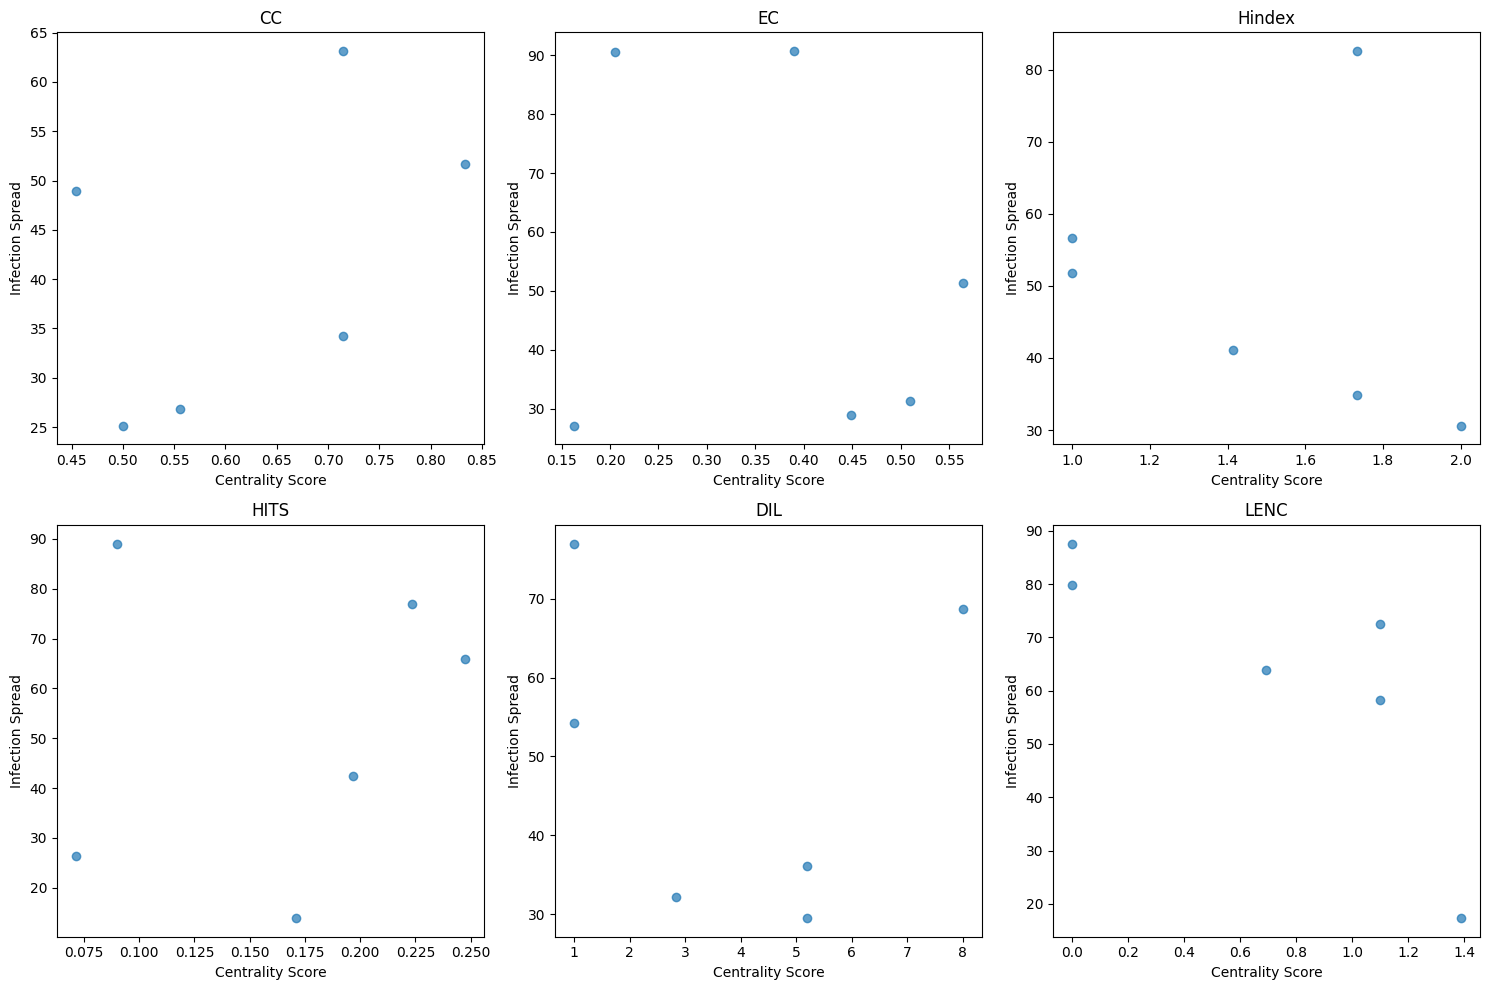

In [52]:
# Calculate standard centrality measures using NetworkX
cc = nx.closeness_centrality(G)
ec = nx.eigenvector_centrality(G)
hindex = {node: np.sqrt(deg) for node, deg in G.degree()}  # Placeholder H-index

# HITS centrality (Authority scores)
hits = nx.hits(G)[1]

# Define custom functions for DIL and LENC centralities
def degree_influence_line(G):
    """ Custom Degree Influence Line centrality (DIL). """
    return {node: deg ** 1.5 for node, deg in G.degree()}

def local_entropy_node_centrality(G):
    """ Custom Local Entropy Node Centrality (LENC). """
    centrality = {}
    for node in G:
        neighbors = list(G.neighbors(node))
        degree = G.degree(node)
        if degree > 0:
            entropy = -sum([(1/degree) * np.log(1/degree) for _ in neighbors])
        else:
            entropy = 0
        centrality[node] = entropy
    return centrality

# Calculate DIL and LENC centralities
dil = degree_influence_line(G)
lenc = local_entropy_node_centrality(G)

# Placeholder infection spread data (replace with SIR model data)
infection_spread = {
    "CC": [random.uniform(0, 100) for _ in cc.values()],
    "EC": [random.uniform(0, 100) for _ in ec.values()],
    "Hindex": [random.uniform(0, 100) for _ in hindex.values()],
    "HITS": [random.uniform(0, 100) for _ in hits.values()],
    "DIL": [random.uniform(0, 100) for _ in dil.values()],
    "LENC": [random.uniform(0, 100) for _ in lenc.values()]
}

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for better visibility
centrality_measures = ["CC", "EC", "Hindex", "HITS", "DIL", "LENC"]
centrality_values = [cc, ec, hindex, hits, dil, lenc]

for i, (cent, values) in enumerate(zip(centrality_measures, centrality_values)):
    row, col = divmod(i, 3)  # Position in 2x3 grid
    axes[row, col].scatter(list(values.values()), infection_spread[cent], alpha=0.7)
    axes[row, col].set_title(cent)
    axes[row, col].set_xlabel("Centrality Score")
    axes[row, col].set_ylabel("Infection Spread")

plt.tight_layout()
plt.show()

## Comparing the results from various algorithms with SIR Model Simulation

In [53]:
# SIR model parameters
beta = 2 * np.mean([d for n, d in G.degree()]) / np.mean([d**2 for n, d in G.degree()])
gamma = 1
steps = 10
simulations = 1000
seed = 42

def sir_model(G, beta, gamma, initial_infected, steps):
    susceptible = set(G.nodes())
    infected = set(initial_infected)
    recovered = set()

    for _ in range(steps):
        new_infected = set()
        for node in infected:
            for neighbor in G.neighbors(node):
                if neighbor in susceptible and random.random() < beta:
                    new_infected.add(neighbor)
            if random.random() < gamma:
                recovered.add(node)
        susceptible -= new_infected
        infected = (infected - recovered) | new_infected

    return infected, recovered

def rank_nodes_sir(G, beta, gamma, steps, simulations, seed=None):
    if seed is not None:
        random.seed(seed)
    influence_scores = {node: 0 for node in G.nodes()}
    for _ in range(simulations):
        initial_infected = random.sample(G.nodes(), 1)
        infected, recovered = sir_model(G, beta, gamma, initial_infected, steps)
        for node in infected | recovered:
            influence_scores[node] += 1
    ranked_nodes = sorted(influence_scores.items(), key=lambda x: x[1], reverse=True)
    return ranked_nodes

# Rank nodes using the SIR model
ranked_nodes_sir = rank_nodes_sir(G, beta, gamma, steps, simulations, seed)

# Calculate centrality measures
ec = nx.eigenvector_centrality(G)
hits = nx.hits(G)[0]
cc = nx.closeness_centrality(G)
hindex = {node: sum(1 for neighbor in G.neighbors(node) if G.degree(neighbor) >= G.degree(node)) for node in G.nodes()}
dil = {node: sum(G.degree(neighbor) for neighbor in G.neighbors(node)) for node in G.nodes()}

# Rank nodes based on centrality measures
ranked_nodes_ec = sorted(ec.items(), key=lambda x: x[1], reverse=True)
ranked_nodes_hits = sorted(hits.items(), key=lambda x: x[1], reverse=True)
ranked_nodes_cc = sorted(cc.items(), key=lambda x: x[1], reverse=True)
ranked_nodes_hindex = sorted(hindex.items(), key=lambda x: x[1], reverse=True)
ranked_nodes_dil = sorted(dil.items(), key=lambda x: x[1], reverse=True)

C:\Users\Kartabya\AppData\Local\Temp\ipykernel_36320\3673434355.py:31: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  initial_infected = random.sample(G.nodes(), 1)


In [54]:
tau, p_value = kendalltau(ranked_nodes_lenc, [item[0] for item in ranked_nodes_sir])
print(f"Kendall's Tau correlation for tiny network: {tau}, p-value: {p_value}")

Kendall's Tau correlation for tiny network: 0.9999999999999999, p-value: 0.002777777777777778


In [55]:
# Prepare the data for the DataFrame
data = {
    "Rank (SIR Model)": [node for rank, (node, score) in enumerate(ranked_nodes_sir[:10], 1)],
    "Score (SIR Model)": [score for rank, (node, score) in enumerate(ranked_nodes_sir[:10], 1)],
    "Score (LENC)": [total_influence.get(node, None) for node in [node for rank, (node, score) in enumerate(ranked_nodes_sir[:10], 1)]],  # LENC influence values
    "Rank (LENC)": ranked_nodes_lenc,
    "Rank (HITS)": [node for rank, (node, score) in enumerate(ranked_nodes_hits[:10], 1)],
    "Score (HITS)": [score for rank, (node, score) in enumerate(ranked_nodes_hits[:10], 1)],
    "Rank (CC)": [node for rank, (node, score) in enumerate(ranked_nodes_cc[:10], 1)],
    "Score (CC)": [score for rank, (node, score) in enumerate(ranked_nodes_cc[:10], 1)],
    "Rank (H-index)": [node for rank, (node, score) in enumerate(ranked_nodes_hindex[:10], 1)],
    "Score (H-index)": [score for rank, (node, score) in enumerate(ranked_nodes_hindex[:10], 1)],
    "Rank (DIL)": [node for rank, (node, score) in enumerate(ranked_nodes_dil[:10], 1)],
    "Score (DIL)": [score for rank, (node, score) in enumerate(ranked_nodes_dil[:10], 1)]
}

# Create the DataFrame
df_rankings = pd.DataFrame(data)

# Display the DataFrame
df_rankings

,Rank (SIR Model),Score (SIR Model),Score (LENC),Rank (LENC),Rank (HITS),Score (HITS),Rank (CC),Score (CC),Rank (H-index),Score (H-index),Rank (DIL),Score (DIL)
0,4,847,13.264723,4,4,0.247351,4,0.833333,2,2,4,9
1,3,842,12.520824,3,3,0.223422,2,0.714286,3,2,3,9
2,2,841,10.618599,2,2,0.196929,3,0.714286,6,2,2,8
3,6,815,8.992206,6,6,0.170959,6,0.555556,1,1,6,7
4,1,721,4.378369,1,5,0.089825,5,0.500000,5,1,5,4
5,5,696,4.266008,5,1,0.071514,1,0.454545,4,0,1,3
